In [127]:
from util import go_to_project_root
go_to_project_root()

CWD cambiado a la raíz del proyecto: /Users/macos/Documents/GitHub/HW2


# Problema 1

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from source.data.loaders import create_dataset
from source.models.var import VAR
from source.data.transform import create_var_dataset
from source.display.hw import hw2 as plots
from source.display.hw.hw1 import save_figure

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cargar datos

In [129]:
path = './data/base_25.xls'
dataset = create_dataset(path, problem=5)

[INFO] ¡Datos cargados exitosamente!


In [130]:
i_reshaped = dataset['i'][12:]
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T

In [131]:
n = X.shape[1] # numero de variables
p = 2 # rezagos

### Modelo

In [92]:
model = VAR(inp_dim=n, 
            c = 4,
            p=p, 
            params_distribution='stationary')
model._is_stationary()

TypeError: VAR.__init__() got an unexpected keyword argument 'inp_dim'

In [132]:
pre_fit_data = model.sample(len(X))
err = model.fit(X)
pos_fit_data = model.sample(len(X))

✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/true_gen.pdf


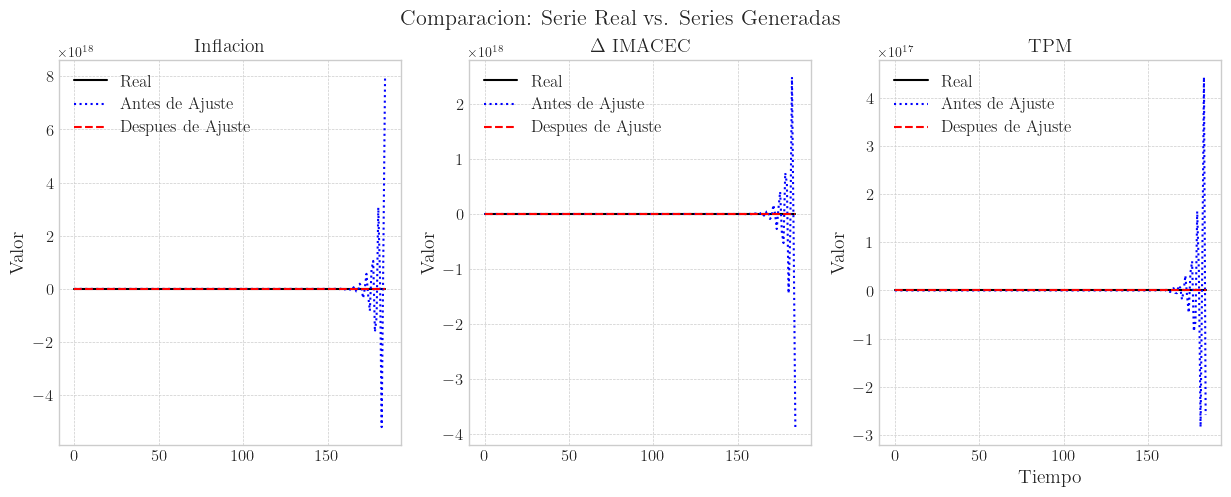

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plots.plot_real_vs_generated(X, pre_fit_data, pos_fit_data, fig=fig, axes=axes,
                             variable_names=['Inflacion', r'$\Delta$ IMACEC', 'TPM'])
save_figure(fig, './presentation/figures/hw2/p2/true_gen.pdf')

In [133]:
import numpy as np
import pandas as pd
import statsmodels.api as sm  
from scipy.stats import f

df = pd.DataFrame(X, columns=['pi', 'y', 'i'])

# Función  de Granger
def granger_test(y, x, lags=1):  
    T = len(y)

    # Matriz de rezagos
    def lag_matrix(series, p):
        T = len(series)
        return np.column_stack([series[p - j : T - j] for j in range(1, p+1)])

    # Variables rezagadas
    y_lagged = lag_matrix(y, lags)
    x_lagged = lag_matrix(x, lags)
    Y = y[lags:]   # variable dependiente

    # Regresión restringida (solo rezagos de Y)
    X_r = sm.add_constant(y_lagged)
    model_r = sm.OLS(Y, X_r).fit()
    RSS_r = np.sum(model_r.resid**2)

    # Regresión no restringida (rezagos de Y + rezagos de X)
    X_nr = sm.add_constant(np.hstack([y_lagged, x_lagged]))
    model_nr = sm.OLS(Y, X_nr).fit()
    RSS_nr = np.sum(model_nr.resid**2)

    # Estadístico F
    p = lags
    F = ((RSS_r - RSS_nr) / p) / (RSS_nr / (T - 2*p - 1))

    # p-value
    p_value = 1 - f.cdf(F, p, T - 2*p - 1)
    
    return F, p_value

# Test 1: pi -> y
print("TEST 1: pi -> y")
F1, p_val1 = granger_test(df['y'].values, df['pi'].values, lags=1)  # <-- aquí defines 1 o 2
print(f"F-statistic: {F1:.4f}")
print(f"p-value: {p_val1:.6f}")
print(f"¿Causalidad significativa (p < 0.05)?: {'SÍ' if p_val1 < 0.05 else 'NO'}")
print("-" * 40)

print("TEST 1: pi -> y")
F1, p_val1 = granger_test(df['y'].values, df['pi'].values, lags=2)  # <-- aquí defines 1 o 2
print(f"F-statistic: {F1:.4f}")
print(f"p-value: {p_val1:.6f}")
print(f"¿Causalidad significativa (p < 0.05)?: {'SÍ' if p_val1 < 0.05 else 'NO'}")
print("-" * 40)

# Test 2: y -> pi
print("TEST 2: y -> pi")  
F2, p_val2 = granger_test(df['pi'].values, df['y'].values, lags=1)
print(f"F-statistic: {F2:.4f}")
print(f"p-value: {p_val2:.6f}")
print(f"¿Causalidad significativa (p < 0.05)?: {'SÍ' if p_val2 < 0.05 else 'NO'}")
print("-" * 40)

print("TEST 2: y -> pi")  
F2, p_val2 = granger_test(df['pi'].values, df['y'].values, lags=2)
print(f"F-statistic: {F2:.4f}")
print(f"p-value: {p_val2:.6f}")
print(f"¿Causalidad significativa (p < 0.05)?: {'SÍ' if p_val2 < 0.05 else 'NO'}")
print("-" * 40)



TEST 1: pi -> y
F-statistic: 2.8310
p-value: 0.094178
¿Causalidad significativa (p < 0.05)?: NO
----------------------------------------
TEST 1: pi -> y
F-statistic: 2.1916
p-value: 0.114705
¿Causalidad significativa (p < 0.05)?: NO
----------------------------------------
TEST 2: y -> pi
F-statistic: 8.8664
p-value: 0.003300
¿Causalidad significativa (p < 0.05)?: SÍ
----------------------------------------
TEST 2: y -> pi
F-statistic: 2.5088
p-value: 0.084208
¿Causalidad significativa (p < 0.05)?: NO
----------------------------------------


In [95]:
from statsmodels.tsa.stattools import grangercausalitytests

# Tu código original primero
path = './data/base_25.xls'
dataset = create_dataset(path, problem=5)
i_reshaped = dataset['i'][12:]
X = np.vstack([dataset['pi'], dataset['y'], i_reshaped]).T
df = pd.DataFrame(X, columns=['pi', 'y', 'i'])

print("TESTS DE GRANGER CON STATSMODELS")
print("="*50)

# Test 1: pi -> y
print("\n1. Test: pi -> y")
result1 = grangercausalitytests(df[['y', 'pi']], maxlag=2, verbose=True)

# Test 2: y -> pi  
print("\n2. Test: y -> pi")
result2 = grangercausalitytests(df[['pi', 'y']], maxlag=2, verbose=True)


[INFO] ¡Datos cargados exitosamente!
TESTS DE GRANGER CON STATSMODELS

1. Test: pi -> y

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8154  , p=0.0951  , df_denom=181, df_num=1
ssr based chi2 test:   chi2=2.8621  , p=0.0907  , df=1
likelihood ratio test: chi2=2.8400  , p=0.0919  , df=1
parameter F test:         F=2.8154  , p=0.0951  , df_denom=181, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1673  , p=0.1175  , df_denom=178, df_num=2
ssr based chi2 test:   chi2=4.4564  , p=0.1077  , df=2
likelihood ratio test: chi2=4.4030  , p=0.1106  , df=2
parameter F test:         F=2.1673  , p=0.1175  , df_denom=178, df_num=2

2. Test: y -> pi

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8177  , p=0.0034  , df_denom=181, df_num=1
ssr based chi2 test:   chi2=8.9639  , p=0.0028  , df=1
likelihood ratio test: chi2=8.7524  , p=0.0031  , df=1
parameter F test:         F=8.8177  , p=0.0034  , df_denom=18

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [79]:
###Problema de Proyecciones Locales

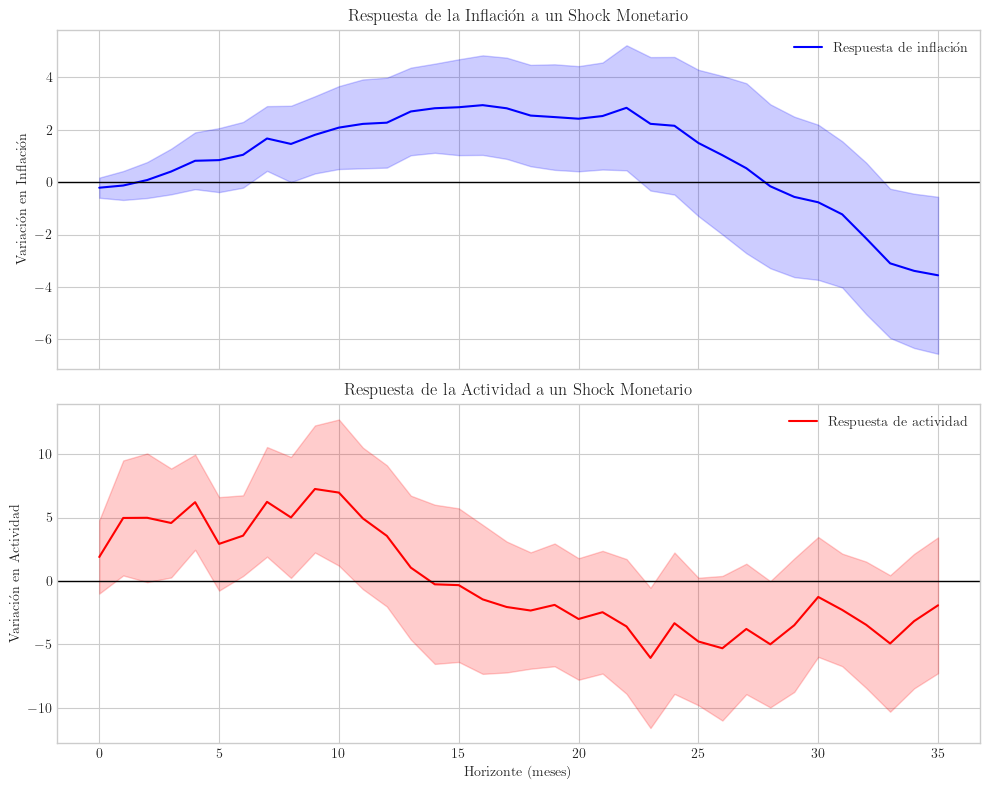

In [149]:


# Primera etapa: regresion de i_t como shock sobre rezagos de pi, y, i
p_lp =12  # Usar mismo número de rezagos

# Crear matriz de variables rezagadas similar a cómo se hizo antes
X_lags = []
for lag in range(1, p_lp + 1):
    for var in ['pi', 'y', 'i']:
        X_lags.append(df[var].shift(lag))


X_lags_df = pd.concat(X_lags, axis=1) # Concatenar todas las columnas de rezagos
X_lags_df.columns = [f'{var}_lag{lag}' for lag in range(1, p_lp + 1) for var in ['pi', 'y', 'i']] # Renombrar columnas
X_lags_df = sm.add_constant(X_lags_df)  # Agregar constante para el OLS. 

# Alinear datos (eliminar NaN de los rezagos)
valid_idx = X_lags_df.dropna().index # Índices válidos
X_lags_valid = X_lags_df.loc[valid_idx] # Matriz de rezagos válida
i_valid = df['i'].loc[valid_idx] # Variable dependiente válida

# Regresión de primera etapa: i_t sobre rezagos de pi, y, i
first_stage = sm.OLS(i_valid, X_lags_valid).fit(cov_type='HC1')  # Errores robustos
# Guardar el shock monetario (residuales) en el DataFrame
df['monetary_shock'] = np.nan
df.loc[valid_idx, 'monetary_shock'] = first_stage.resid  # Shock es el residual

# Paso 2: Proyecciones Locales para diferentes horizontes
horizons =36  # Número de horizontes a proyectar

# Preparar arrays para almacenar resultados
responses_pi = np.zeros(horizons)
responses_y = np.zeros(horizons)
se_pi = np.zeros(horizons)
se_y = np.zeros(horizons)

for h in range(horizons):
    # Variables dependientes desplazadas
    df[f'pi_h{h}'] = df['pi'].shift(-h)
    df[f'y_h{h}'] = df['y'].shift(-h)

    # Eliminar observaciones con NaN para este horizonte
    temp_df = df.dropna(subset=[f'pi_h{h}', f'y_h{h}', 'monetary_shock']).copy()

    # Variables de control: tomar X_lags_df en los mismos índices de temp_df
    X_controls = X_lags_df.loc[temp_df.index].copy()

    # Reunir shock + controles
    X = pd.concat([temp_df['monetary_shock'], X_controls], axis=1)

    # Regressión para inflación (pi)
    y_pi = temp_df[f'pi_h{h}']
    model_pi = sm.OLS(y_pi, X).fit(cov_type='HC1')
    responses_pi[h] = model_pi.params['monetary_shock']
    se_pi[h] = model_pi.bse['monetary_shock']

    # Regressión para crecimiento (y)
    y_y = temp_df[f'y_h{h}']
    model_y = sm.OLS(y_y, X).fit(cov_type='HC1')
    responses_y[h] = model_y.params['monetary_shock']
    se_y[h] = model_y.bse['monetary_shock']

# Paso 3: Graficar las Funciones de Impulso-Respuesta
horizons_range = np.arange(horizons)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(horizons_range, responses_pi, label='Respuesta de inflación', color='blue')
ax1.fill_between(
    horizons_range,
    responses_pi - 1.96 * se_pi,
    responses_pi + 1.96 * se_pi,
    color='blue', alpha=0.2
)
ax1.axhline(0, color='black', linewidth=1)
ax1.set_title("Respuesta de la Inflación a un Shock Monetario")
ax1.set_ylabel("Variación en Inflación")
ax1.legend()

# Gráfico para actividad (y)
ax2.plot(horizons_range, responses_y, label='Respuesta de actividad', color='red')
ax2.fill_between(
    horizons_range,
    responses_y - 1.96 * se_y,
    responses_y + 1.96 * se_y,
    color='red', alpha=0.2
)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title("Respuesta de la Actividad a un Shock Monetario")
ax2.set_xlabel("Horizonte (meses)")
ax2.set_ylabel("Variación en Actividad")
ax2.legend()

plt.tight_layout()
plt.show()


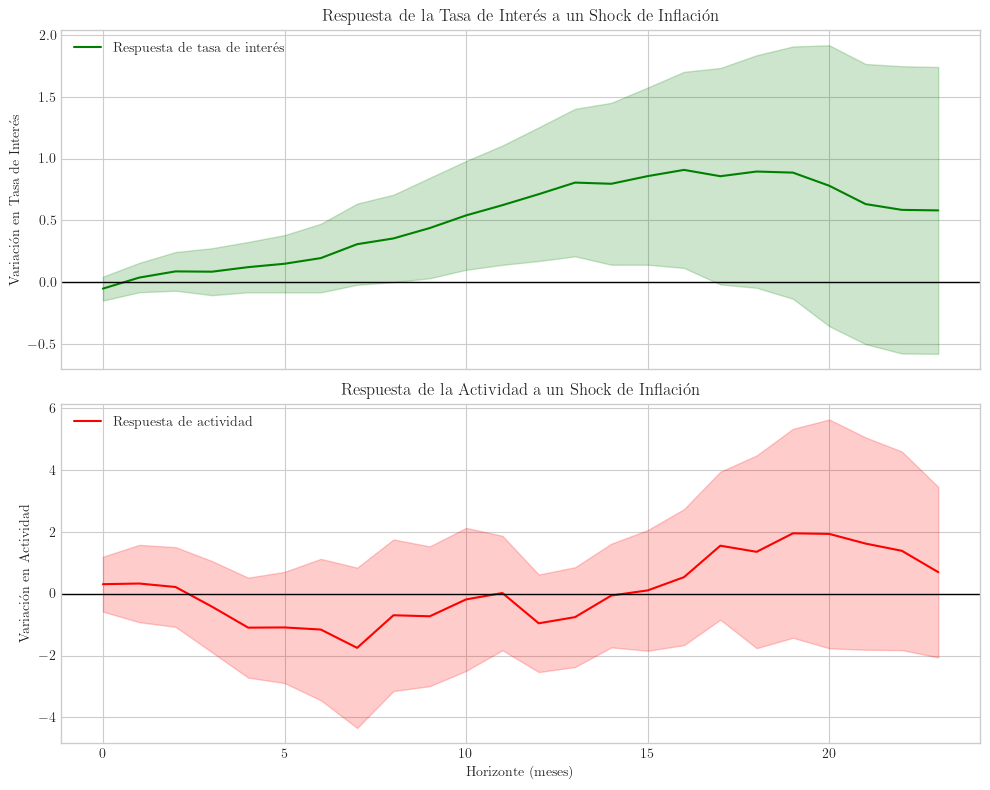

In [ ]:
p_lp = 12  # Usar mismo número de rezagos

# Crear matriz de variables rezagadas
X_lags = []
for lag in range(1, p_lp + 1):
    for var in ['pi', 'y', 'i']:
        X_lags.append(df[var].shift(lag))

X_lags_df = pd.concat(X_lags, axis=1) # Concatenar todas las columnas de rezagos
X_lags_df.columns = [f'{var}_lag{lag}' for lag in range(1, p_lp + 1) for var in ['pi', 'y', 'i']] # Renombrar columnas
X_lags_df = sm.add_constant(X_lags_df)  # Agregar constante para el OLS. 

# Alinear datos (eliminar NaN de los rezagos)
valid_idx = X_lags_df.dropna().index # Índices válidos
X_lags_valid = X_lags_df.loc[valid_idx] # Matriz de rezagos válida
pi_valid = df['pi'].loc[valid_idx] # Variable dependiente válida (ahora es pi)

# Regresión de primera etapa: pi_t sobre rezagos de pi, y, i
first_stage = sm.OLS(pi_valid, X_lags_valid).fit(cov_type='HC1')  # Errores robustos
# Guardar el shock de inflación (residuales) en el DataFrame
df['inflation_shock'] = np.nan
df.loc[valid_idx, 'inflation_shock'] = first_stage.resid  # Shock es el residual

# Paso 2: Proyecciones Locales para diferentes horizontes
horizons = 36  # Número de horizontes a proyectar

# Preparar arrays para almacenar resultados
responses_i = np.zeros(horizons)  # Ahora respuesta de tasa de interés
responses_y = np.zeros(horizons)  # Respuesta de crecimiento
se_i = np.zeros(horizons)
se_y = np.zeros(horizons)

for h in range(horizons):
    # Variables dependientes desplazadas
    df[f'i_h{h}'] = df['i'].shift(-h)  # Ahora miramos respuesta de tasa de interés
    df[f'y_h{h}'] = df['y'].shift(-h)   # y respuesta de crecimiento

    # Eliminar observaciones con NaN para este horizonte
    temp_df = df.dropna(subset=[f'i_h{h}', f'y_h{h}', 'inflation_shock']).copy()

    # Variables de control: tomar X_lags_df en los mismos índices de temp_df
    X_controls = X_lags_df.loc[temp_df.index].copy()

    # Reunir shock + controles
    X = pd.concat([temp_df['inflation_shock'], X_controls], axis=1)

    # Regresión para tasa de interés (i)
    y_i = temp_df[f'i_h{h}']
    model_i = sm.OLS(y_i, X).fit(cov_type='HC1')
    responses_i[h] = model_i.params['inflation_shock']  # Coeficiente del shock de inflación
    se_i[h] = model_i.bse['inflation_shock']

    # Regresión para crecimiento (y)
    y_y = temp_df[f'y_h{h}']
    model_y = sm.OLS(y_y, X).fit(cov_type='HC1')
    responses_y[h] = model_y.params['inflation_shock']  # Coeficiente del shock de inflación
    se_y[h] = model_y.bse['inflation_shock']

# Paso 3: Graficar las Funciones de Impulso-Respuesta
horizons_range = np.arange(horizons)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico para tasa de interés (i)
ax1.plot(horizons_range, responses_i, label='Respuesta de tasa de interés', color='green')
ax1.fill_between(
    horizons_range,
    responses_i - 1.96 * se_i,
    responses_i + 1.96 * se_i,
    color='green', alpha=0.2
)
ax1.axhline(0, color='black', linewidth=1)
ax1.set_title("Respuesta de la Tasa de Interés a un Shock de Inflación")
ax1.set_ylabel("Variación en Tasa de Interés")
ax1.legend()

# Gráfico para actividad (y)
ax2.plot(horizons_range, responses_y, label='Respuesta de actividad', color='red')
ax2.fill_between(
    horizons_range,
    responses_y - 1.96 * se_y,
    responses_y + 1.96 * se_y,
    color='red', alpha=0.2
)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title("Respuesta de la Actividad a un Shock de Inflación")
ax2.set_xlabel("Horizonte (meses)")
ax2.set_ylabel("Variación en Actividad")
ax2.legend()

plt.tight_layout()
plt.show()

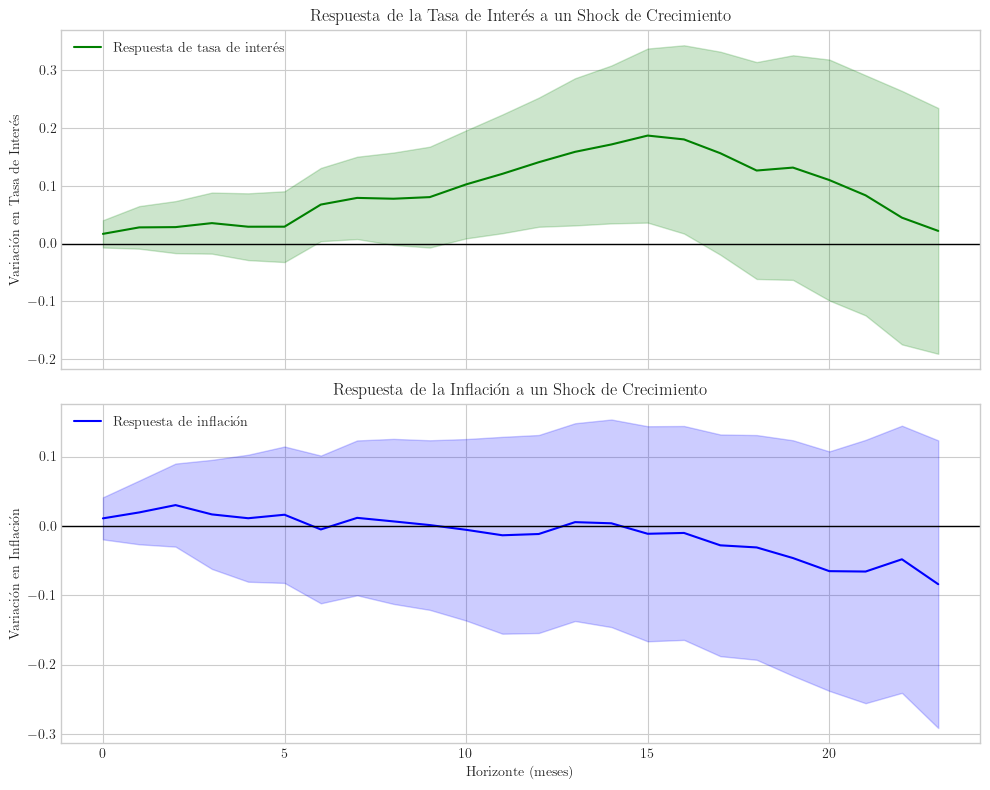

In [ ]:
p_lp = 12  # Usar mismo número de rezagos

# Crear matriz de variables rezagadas
X_lags = []
for lag in range(1, p_lp + 1):
    for var in ['pi', 'y', 'i']:
        X_lags.append(df[var].shift(lag))

X_lags_df = pd.concat(X_lags, axis=1) # Concatenar todas las columnas de rezagos
X_lags_df.columns = [f'{var}_lag{lag}' for lag in range(1, p_lp + 1) for var in ['pi', 'y', 'i']] # Renombrar columnas
X_lags_df = sm.add_constant(X_lags_df)  # Agregar constante para el OLS. 

# Alinear datos (eliminar NaN de los rezagos)
valid_idx = X_lags_df.dropna().index # Índices válidos
X_lags_valid = X_lags_df.loc[valid_idx] # Matriz de rezagos válida
y_valid = df['y'].loc[valid_idx] # Variable dependiente válida (ahora es y)

# Regresión de primera etapa: y_t sobre rezagos de pi, y, i
first_stage = sm.OLS(y_valid, X_lags_valid).fit(cov_type='HC1')  # Errores robustos
# Guardar el shock de crecimiento (residuales) en el DataFrame
df['growth_shock'] = np.nan
df.loc[valid_idx, 'growth_shock'] = first_stage.resid  # Shock es el residual

# Paso 2: Proyecciones Locales para diferentes horizontes
horizons = 36  # Número de horizontes a proyectar

# Preparar arrays para almacenar resultados
responses_i = np.zeros(horizons)  # Respuesta de tasa de interés
responses_pi = np.zeros(horizons)  # Respuesta de inflación
se_i = np.zeros(horizons)
se_pi = np.zeros(horizons)

for h in range(horizons):
    # Variables dependientes desplazadas
    df[f'i_h{h}'] = df['i'].shift(-h)  # Respuesta de tasa de interés
    df[f'pi_h{h}'] = df['pi'].shift(-h)  # Respuesta de inflación

    # Eliminar observaciones con NaN para este horizonte
    temp_df = df.dropna(subset=[f'i_h{h}', f'pi_h{h}', 'growth_shock']).copy()

    # Variables de control: tomar X_lags_df en los mismos índices de temp_df
    X_controls = X_lags_df.loc[temp_df.index].copy()

    # Reunir shock + controles
    X = pd.concat([temp_df['growth_shock'], X_controls], axis=1)

    # Regresión para tasa de interés (i)
    y_i = temp_df[f'i_h{h}']
    model_i = sm.OLS(y_i, X).fit(cov_type='HC1')
    responses_i[h] = model_i.params['growth_shock']  # Coeficiente del shock de crecimiento
    se_i[h] = model_i.bse['growth_shock']

    # Regresión para inflación (pi)
    y_pi = temp_df[f'pi_h{h}']
    model_pi = sm.OLS(y_pi, X).fit(cov_type='HC1')
    responses_pi[h] = model_pi.params['growth_shock']  # Coeficiente del shock de crecimiento
    se_pi[h] = model_pi.bse['growth_shock']

# Paso 3: Graficar las Funciones de Impulso-Respuesta
horizons_range = np.arange(horizons)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico para tasa de interés (i)
ax1.plot(horizons_range, responses_i, label='Respuesta de tasa de interés', color='green')
ax1.fill_between(
    horizons_range,
    responses_i - 1.96 * se_i,
    responses_i + 1.96 * se_i,
    color='green', alpha=0.2
)
ax1.axhline(0, color='black', linewidth=1)
ax1.set_title("Respuesta de la Tasa de Interés a un Shock de Crecimiento")
ax1.set_ylabel("Variación en Tasa de Interés")
ax1.legend()

# Gráfico para inflación (pi)
ax2.plot(horizons_range, responses_pi, label='Respuesta de inflación', color='blue')
ax2.fill_between(
    horizons_range,
    responses_pi - 1.96 * se_pi,
    responses_pi + 1.96 * se_pi,
    color='blue', alpha=0.2
)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title("Respuesta de la Inflación a un Shock de Crecimiento")
ax2.set_xlabel("Horizonte (meses)")
ax2.set_ylabel("Variación en Inflación")
ax2.legend()

plt.tight_layout()
plt.show() 
